In [26]:
import pandas as pd 
import numpy as np

In [27]:
df = pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_1.csv",header=None)

In [28]:
df.columns = ['time','stkcd','open','high','low','close','volume']

In [29]:
close_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    close_df[sub_df[0]] = sub_df[1].reset_index().close

In [30]:
close_df

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350
0,19.18884,33.5940,84.50574,5.2734,203.4120,53.5260,210.0780,27.0600,33.64944,198.6600,...,59.4000,105.2700,103.6200,106.14252,30.77646,87.96810,28.3140,187.5060,107.7780,97.04046
1,20.59662,33.3300,85.08852,5.7024,199.9140,50.4240,210.5400,26.4660,34.98990,195.6900,...,58.1460,109.5600,106.1940,106.14252,32.01594,87.96810,29.0400,188.5620,109.6260,97.04046
2,21.64734,34.1880,98.35320,5.3526,209.6160,57.6840,210.4080,26.9280,38.09388,184.1400,...,59.2020,104.3460,106.2600,108.44988,31.65162,88.36476,30.0300,189.0240,116.0280,97.04046
3,21.50016,34.6500,94.14702,6.7980,200.5080,62.3700,208.0320,26.3340,37.52958,202.6200,...,59.5980,105.9960,107.9100,108.44988,32.23506,88.36476,29.9640,187.0440,104.8740,94.29090
4,22.06776,33.8580,95.44128,7.9860,204.6000,64.9440,223.1460,26.2680,38.16450,199.9800,...,60.1260,105.6000,107.9100,109.43922,32.23506,88.36476,30.3600,192.7200,107.2500,97.04046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,17.52828,206.9694,81.34170,15.1998,310.3122,120.7008,73.3128,72.2964,11.73546,14.8500,...,59.4000,107.5800,111.5400,99.66000,63.33954,46.17624,69.6300,240.0684,141.5238,215.16000
1096,17.08278,205.4646,82.30596,15.8400,312.3318,122.5158,73.1874,73.5240,11.45166,15.0546,...,59.4000,109.7382,112.3320,99.66000,61.71330,47.66520,67.6104,238.9398,142.3818,218.55900
1097,16.83462,200.5146,80.88234,15.5298,309.7842,123.2220,70.9500,76.9230,11.80278,15.0480,...,59.4000,110.8206,110.9460,98.20800,61.58196,45.96042,67.2210,238.5438,139.1808,218.69760
1098,16.48152,202.0524,80.35830,15.5760,312.0942,123.8358,70.9698,74.8374,11.71500,15.0480,...,59.0766,106.9860,109.6260,98.67000,61.53114,46.45674,69.3000,240.9660,139.7418,216.45360


In [31]:
high_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    high_df[sub_df[0]] = sub_df[1].reset_index().high

In [32]:
low_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    low_df[sub_df[0]] = sub_df[1].reset_index().low

In [187]:
highs = high_df.values
lows = low_df.values
closes = close_df.values

In [34]:
import talib

In [105]:
def get_cci(highs,lows,closes,p):
    h = highs[-2*p:]
    l = lows[-2*p:]
    c = closes[-2*p:]

    tp = (h + l + c) / 3

    ret = np.cumsum(tp, axis=0)
    ret[p:] = ret[p:] - ret[:-p]
    ma = ret[p:] / p
    md = np.mean(tp[p:]-ma,axis=0)
    cci = (tp[-1] - ma[-1]) / (0.015 * md)
    return cci

In [107]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [145]:
def get_kdj(highs,lows,closes,fkp=9,skp=3,sdp=3):
    hh = np.max(rolling_window(highs.T,fkp),axis=2).T # highest high
    ll = np.min(rolling_window(lows.T,fkp),axis=2).T # lowest low
    rsv = 100 * (closes[-hh.shape[0]:] - ll) / (hh - ll)
    K = np.mean(rolling_window(rsv.T,skp),axis=2).T
    D = np.mean(rolling_window(K.T,sdp),axis=2).T[-1]
    K = K[-1]
    J = 3 * D - 2 * K
    return K,D,J

In [170]:
def get_rsi(closes,p=9):
    '''
    Args:
        closes: 2D-array of close prices, time as row indexes and each stock for one column
        p: time period
    Return:
        cci: Commodity Channel Index of all stocks as a 1D-array
    '''
    p = 14
    pct = closes[-p:] / closes[-p-1:-1] - 1
    up = pct 
    up[up<0] = np.nan 
    up = np.nanmean(up,axis=0)
    down = pct 
    down[down>0] = np.nan 
    down = np.nanmean(down,axis=0)
    rsi = 100 - (100 / (1 + up/down))
    return rsi

In [168]:
def get_trix(closes,p=14):
    w = np.asarray([np.power(((p-1)/(p+1)),x+1) for x in range(p)])
    w = np.asarray([np.power(((p-1)/(p+1)),p-x-1) for x in range(p)]) * 2 / (p + 1)
    ema1 = np.average(rolling_window(closes[-3*p:].T,p),axis=2,weights=w)
    ema2 = np.average(rolling_window(ema1,p),axis=2,weights=w)
    ema3 = np.average(rolling_window(ema2,p),axis=2,weights=w).T
    trix = 100 * (ema3[-1] / ema3[-2] - 1)
    return trix

array([-3.20034233e-01, -5.40660374e-01, -1.81110794e-01,  4.42513111e-01,
        1.15696111e-01,  1.47725827e-01,  1.49133094e-02,  1.11123494e-01,
       -1.21236117e-01,  1.16224932e-01,  1.21914941e+00,  8.20404473e-02,
        9.60090184e-02,  2.79767276e-01,  1.07153489e-01,  9.16461141e-01,
       -5.69223614e-02, -8.27705204e-02,  5.08421998e-02, -4.76070912e-01,
        8.38824122e-02,  2.55704954e-01,  2.54133353e-01, -3.91573188e-01,
       -3.36081283e-02,  8.60150436e-02, -1.39659576e-01,  1.24482923e-01,
       -1.85505220e-02, -3.74595093e-02, -4.06606400e-03,  3.73498511e-02,
       -2.02152368e-01, -1.68067261e-02,  6.53173768e-01, -2.86336436e-01,
        4.95986500e-01, -8.82250716e-02, -4.37276749e-01, -4.16758265e-01,
        1.10930468e-01,  3.35310735e-01,  3.83861660e-01,  3.36346436e-02,
       -2.05974776e-01,  1.88288623e-01,  1.79028870e-01,  3.35964132e-01,
       -6.88584256e-02, -6.39760190e-02, -3.62388630e-01, -4.02396441e-01,
       -4.43188089e-01, -

In [188]:
closes

array([[ 19.18884,  33.594  ,  84.50574, ..., 187.506  , 107.778  ,
         97.04046],
       [ 20.59662,  33.33   ,  85.08852, ..., 188.562  , 109.626  ,
         97.04046],
       [ 21.64734,  34.188  ,  98.3532 , ..., 189.024  , 116.028  ,
         97.04046],
       ...,
       [ 16.83462, 200.5146 ,  80.88234, ..., 238.5438 , 139.1808 ,
        218.6976 ],
       [ 16.48152, 202.0524 ,  80.3583 , ..., 240.966  , 139.7418 ,
        216.4536 ],
       [ 15.76674, 201.5508 ,  80.94702, ..., 238.491  , 141.174  ,
        221.1264 ]])

In [190]:
rolling_window(closes[-3*p:].transpose(),p).shape

(351, 29, 14)

In [195]:

ema1

array([[ 19.33903995,  19.28174571,  19.2362118 , ...,  17.62636514,
         17.44278204,  17.16871289],
       [228.96961871, 230.20336258, 230.29945509, ..., 212.13538079,
        210.31670625, 208.63399279],
       [ 84.13752485,  84.23131279,  84.56314497, ...,  82.3468585 ,
         82.01298355,  81.79284698],
       ...,
       [241.58089181, 242.31050501, 243.03735713, ..., 238.30838741,
        238.74916751, 238.76674142],
       [150.59515231, 150.0978625 , 149.46389019, ..., 142.41093271,
        141.9461169 , 141.75028814],
       [214.99843884, 216.75263622, 217.71150335, ..., 213.96398895,
        214.10537565, 214.90486774]])

In [197]:

ema3.T

array([[ 18.12992435, 224.51704609,  83.93007625, ..., 239.03235767,
        143.1690863 , 216.42075879],
       [ 18.08179497, 223.4069273 ,  83.7951215 , ..., 238.85462713,
        143.14518439, 216.07765177],
       [ 18.02392704, 222.19905457,  83.64335949, ..., 238.71704341,
        143.09705848, 215.7568715 ]])

In [144]:
K.shape,D.shape,J.shape

((351,), (351,), (351,))

In [59]:
import time
start = time.time()
np.divide(h + l + c,3)
end = time.time()
print((end-start)*1000)

1.028299331665039


In [63]:
start = time.time()
(h + l + c) / 3
end = time.time()
print((end-start)*1000)

0.9968280792236328


In [61]:
np.mean(h + l + c,axis=0).shape

(351,)

In [ ]:
def 

In [117]:
closes.shape[:-1]

(1100,)

In [129]:
mx = np.max(rolling_window(closes.transpose(),10),axis=2).transpose()

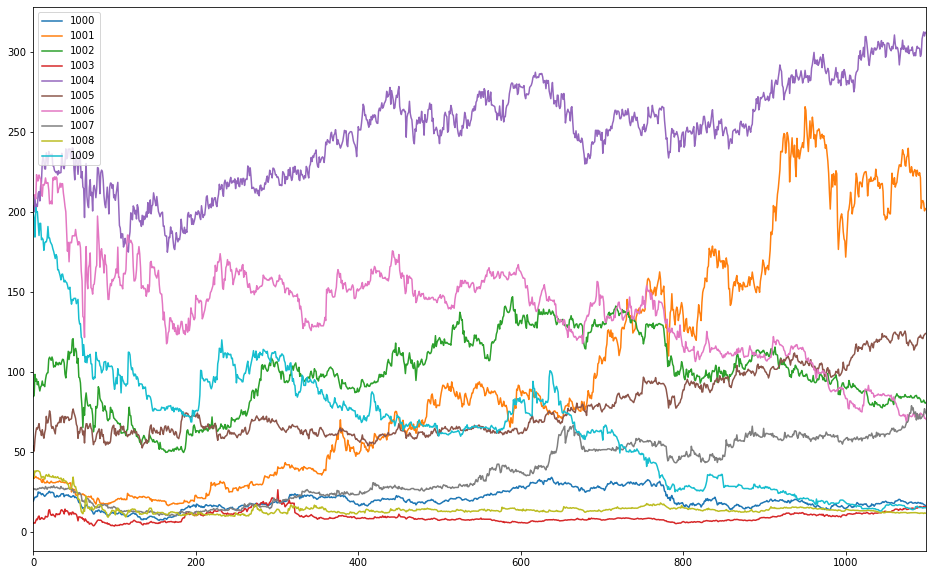

In [58]:

close_df.iloc[:,:10].plot(figsize=(16,10))